In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from keras.layers import Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import requests
from io import BytesIO
from zipfile import ZipFile
import json
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import load_img, image_dataset_from_directory
import seaborn as sns

-----------------
# Read train and test sets

In [28]:
training_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/train', image_size = (128, 128), batch_size = None, seed = 123)]
test_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/test', image_size = (128, 128), batch_size = None, seed = 123)]

with open("classlabels.txt") as infile:
    labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())
print("The 20 classes are: " + ", ".join(str(l) for l in labels.values()))

Found 1792 files belonging to 20 classes.
Found 1022 files belonging to 20 classes.
The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


-----------
# Select labels

In [29]:
#labels_to_keep = list(range(20))
labels_to_keep = [2, 4, 9, 10, 13, 19] # Change this to determine which labels to keep (or change to list(range(20)) to keep all labels)
num_classes = len(labels_to_keep)

x_train = np.array([image for image, label in training_set if label in labels_to_keep])
y_train = np.array([labels_to_keep.index(label) for image, label in training_set if label in labels_to_keep])
x_test = np.array([image for image, label in test_set if label in labels_to_keep])
y_test = np.array([labels_to_keep.index(label) for image, label in test_set if label in labels_to_keep])

finallabels = dict([(i, labels[l]) for i, l in enumerate(labels_to_keep)])
print("The " + str(num_classes) + " classes are: " + ", ".join(str(l) for l in finallabels.values()))

The 6 classes are: limit60, noleft, goright, keepright, pedestrcross, noentry


----------------
# Plot example data

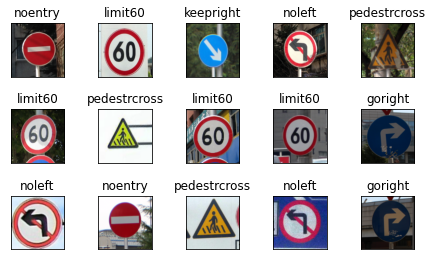

In [30]:
fig = plt.figure()
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    img = array_to_img(x_train[i])
    plt.imshow(img)
    plt.title(finallabels[y_train[i]])
    plt.xticks([])
    plt.yticks([])
plt.savefig("visualizations/example-data.png",bbox_inches='tight')

C:\Users\Christina\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

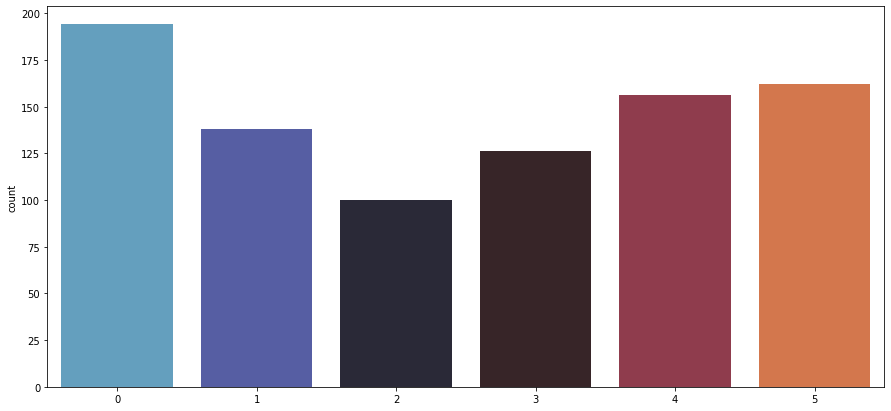

In [31]:
# we visualize the number of examples in each class
plt.figure(figsize=(15,7))
sns.countplot(y_train,palette='icefire')  

------------------------
# Explore and pre-process the data

In [32]:
# check the number of samples
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

876 train samples
444 test samples


In [33]:
type(x_train)

numpy.ndarray

In [34]:
x_train.shape # RGB images have a depth of 3

(876, 128, 128, 3)

In [35]:
x_test.shape

(444, 128, 128, 3)

In [36]:
x_train.min()

0.0

In [37]:
x_train.max()

255.0

In [38]:
# Normalize pixel values to be between 0 and 1 by dividing by 255. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

In [39]:
x_train.min()

0.0

In [40]:
x_train.max()

1.0

# Model

In [41]:
def create_CNN(input_shape, num_classes):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(64, activation ='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(10))
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='softmax'))     
    return model

In [45]:
input_shape = x_train.shape[1:4]
num_classes = 6

model = create_CNN(input_shape, num_classes)
adam = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)     

In [48]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test)

Epoch 1/50
28/28 [==============================] - 11s 402ms/step - loss: 1.6236 - accuracy: 0.3550 - val_loss: 1.4159 - val_accuracy: 0.6757
Epoch 2/50
28/28 [==============================] - 12s 430ms/step - loss: 1.3162 - accuracy: 0.4737 - val_loss: 1.1980 - val_accuracy: 0.6036
Epoch 3/50
28/28 [==============================] - 13s 478ms/step - loss: 1.1628 - accuracy: 0.5468 - val_loss: 0.9752 - val_accuracy: 0.7387
Epoch 4/50
28/28 [==============================] - 13s 483ms/step - loss: 1.0609 - accuracy: 0.5902 - val_loss: 0.9255 - val_accuracy: 0.7703
Epoch 5/50
28/28 [==============================] - 14s 500ms/step - loss: 0.9390 - accuracy: 0.6381 - val_loss: 0.7832 - val_accuracy: 0.7838
Epoch 6/50
28/28 [==============================] - 16s 568ms/step - loss: 0.8690 - accuracy: 0.6553 - val_loss: 0.6605 - val_accuracy: 0.8559
Epoch 7/50
28/28 [==============================] - 14s 515ms/step - loss: 0.8357 - accuracy: 0.6724 - val_loss: 0.7130 - val_accuracy: 0.7973

14/14 - 2s - loss: 0.1795 - accuracy: 0.9369 - 2s/epoch - 130ms/step


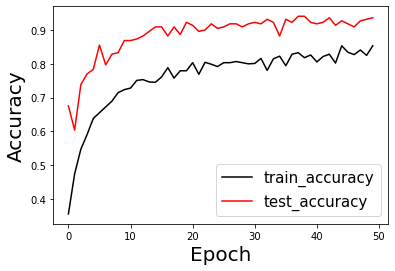

In [49]:
plt.plot(history.history['accuracy'], label='train_accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'test_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

14/14 - 2s - loss: 0.1795 - accuracy: 0.9369 - 2s/epoch - 124ms/step


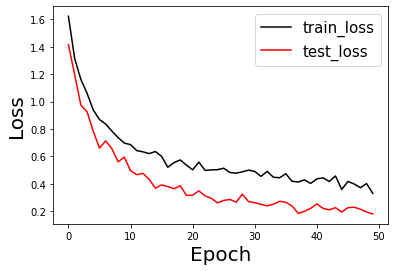

In [50]:
plt.plot(history.history['loss'], label='train_loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'test_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='upper right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')

In [51]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("The accuracy of the model is:")
print(test_acc)

14/14 - 2s - loss: 0.1795 - accuracy: 0.9369 - 2s/epoch - 120ms/step
The accuracy of the model is:
0.9369369149208069


14/14 [==============================] - 1s 78ms/step


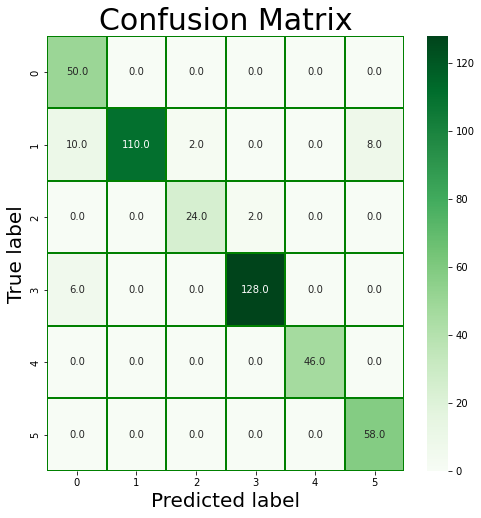

In [56]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# evaluate on test set
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = y_test
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)

# plot heatmap to illustrate confusion matrix
figure,axs = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mtx,annot=True,fmt='.1f',cmap='Greens',linewidths=0.01,linecolor='green',ax=axs)
plt.title('Confusion Matrix', size=30)
plt.xlabel('Predicted label', size=20)
plt.ylabel('True label', size=20)
plt.savefig("visualizations/cm.png",bbox_inches='tight')
plt.show()

In [60]:
results_val = model.evaluate(x_test,y_test)
print('validation accuracy : {}'.format(results_val[1]))

14/14 [==============================] - 1s 86ms/step - loss: 0.1795 - accuracy: 0.9369
validation accuracy : 0.9369369149208069


In [61]:
results_val

[0.17945824563503265, 0.9369369149208069]